In [22]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
from scipy.sparse.linalg import spsolve, gmres
from scipy import sparse

In [23]:
%run geometry_mesh.ipynb #Mesh geometry

In [24]:
x_min = min(x_no)
x_max = max(x_no)

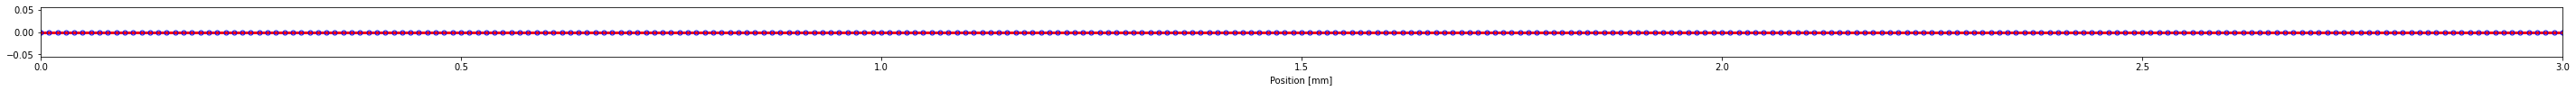

In [25]:
fig = plt.figure(figsize=(50,1))
ax = fig.add_subplot(111)
ax.set_xlim(10*x_min,10*x_max)
ax.set_xlabel("Position [mm]")

for i in range(Ne):
    ax.plot([10*x_no[i], 10*x_no[i+1]], [0,0], color="red", linewidth = 3)
    
for i in range(Nn):
    ax.plot(10*x_no[i], 0, marker="o", color = "blue", markersize = 5, fillstyle='none')
    

In [26]:
%run Model_parameters.ipynb #Parameters for 1d Transistor

x_no = x_no/r_norm #Normalize distance

In [27]:
#Setting up arrays for the quantities to calculate

n = np.empty(Nn) #electron concetration
p = np.empty(Nn) #hole concentration
Nd = np.empty(Nn) #donor ions concentration
Na = np.empty(Nn) #acceptor ions concentration
U = np.empty(Nn) #recombination rate
V = np.empty(Nn) #electric potential
# e_Vp = np.empty(Nn) #e^HQFP
# e_Vn = np.empty(Nn) #e^(-EQFP)


In [28]:
#Setting up initial values

node_count = 0
for i in range(N_e):
    Nd[node_count] = N_DE
    Na[node_count] = 0
    n[node_count] = 1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2)))
    p[node_count] = 1/n[node_count]
    node_count += 1
    
for i in range(N_b):
    Nd[node_count] = 0
    Na[node_count] = N_AB
    p[node_count] = 1/2*(N_AB + m.sqrt(N_AB**2 + 4*(n_norm**2)))
    n[node_count] = 1/p[node_count]
    node_count += 1
    
for i in range(N_c+1):
    Nd[node_count] = N_DC
    Na[node_count] = 0
    n[node_count] = 1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2)))
    p[node_count] = 1/n[node_count]
    node_count += 1
    
n = n/n_norm
p = p/n_norm
Nd = Nd/n_norm
Na = Na/n_norm

#calculate recombination rate
for i in range(Nn):
    U[i] = (n[i]*p[i] - 1)/(tau_p*(n[i]+1) + tau_n*(p[i]+1))


In [29]:
%run matrix_assembly_1d.ipynb #Matrix assembly for F^1 and F^2

#Built in voltages and carrier concentrations at contacts
V_built_EB = m.log(N_DE*N_AB)
V_built_CB = m.log(N_DC*N_AB)
M = int(N_e + N_b/2) # Middle point potential V[M] = 0

In [30]:
#Impose boundary conditions 

#AV = B -- Matrix equation solved below - imposing boundary conditions
A = sparse.lil_matrix.copy(F_1)
B = sparse.lil_matrix.dot(F_2,(p-n+Nd-Na))
A[0,0] = 0
A[0,1] = 0
A[0,0] = 1
A[M-1,M-2] = 0
A[M-1,M-1] = 0
A[M-1,M] = 0
A[M-1,M-1] = 1
A[Nn-1,Nn-2] = 0
A[Nn-1,Nn-1] = 0
A[Nn-1,Nn-1] = 1


B[0] = V_built_EB
B[M-1] = 0
B[Nn-1] = V_built_CB

In [31]:
class gmres_counter(object):
    def __init__(self):
        self.relres = []
        self.niter = 0
    def __call__(self, rk=None):
        self.relres.append(rk)
        self.niter += 1

Text(0, 0.5, 'Relative Residual')

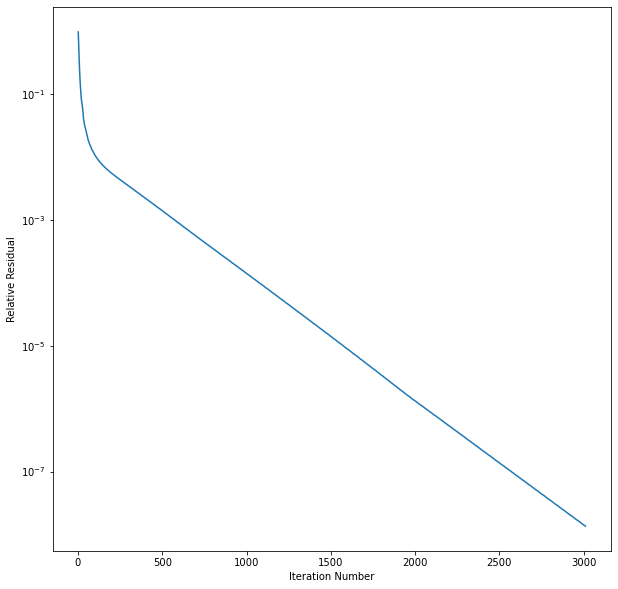

In [32]:
#Solve for initial potential V

counter = gmres_counter()

V, info = gmres(A,B,tol=1e-8,callback=counter)
relres = np.asarray(counter.relres)
iterations = np.arange(1, relres.size+1,1)
figR = plt.figure(figsize=(10,10))
axR = figR.add_subplot(1,1,1)
axR.plot(iterations,relres)
axR.set_yscale('log')
axR.set_xlabel('Iteration Number')
axR.set_ylabel('Relative Residual')

Text(0, 0.5, 'Potential [V]')

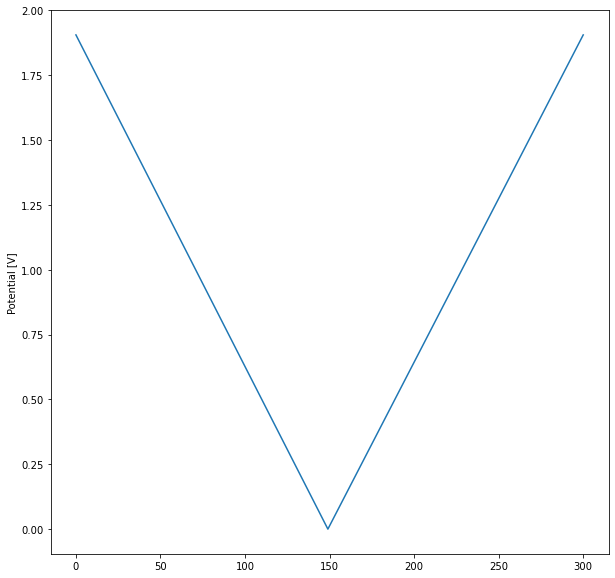

In [33]:
#initial potential distribution

lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(lin,V*V_norm)
ax.set_ylabel("Potential [V]")

In [34]:
#Calculating matrix G^1 for a given potential distribution

G_1 = sparse.lil_matrix((Nn,Nn))

%run G_matrix_assembly.ipynb

In [35]:
#impose boundary condition for n_new and p_new calculations

C = G_1.multiply(1/gamma_n) - F_1.multiply(1/gamma_n)
D = sparse.lil_matrix.dot(F_2,U)

C[0,0] = 0
C[0,1] = 0
C[0,0] = 1
C[Nn-1,Nn-2] = 0
C[Nn-1,Nn-1] = 0
C[Nn-1,Nn-1] = 1

D[0] = (1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2))))/n_norm
D[Nn-1] = (1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2))))/n_norm


E = G_1.multiply(1/gamma_p) - F_1.multiply(1/gamma_p)
F = sparse.lil_matrix.dot(F_2,U)

E[0,0] = 0
E[0,1] = 0
E[0,0] = 1
E[Nn-1,Nn-2] = 0
E[Nn-1,Nn-1] = 0
E[Nn-1,Nn-1] = 1

F[0] = 1/((1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2))))/n_norm)
F[Nn-1] = 1/((1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2))))/n_norm)


Text(0, 0.5, 'Relative Residual')

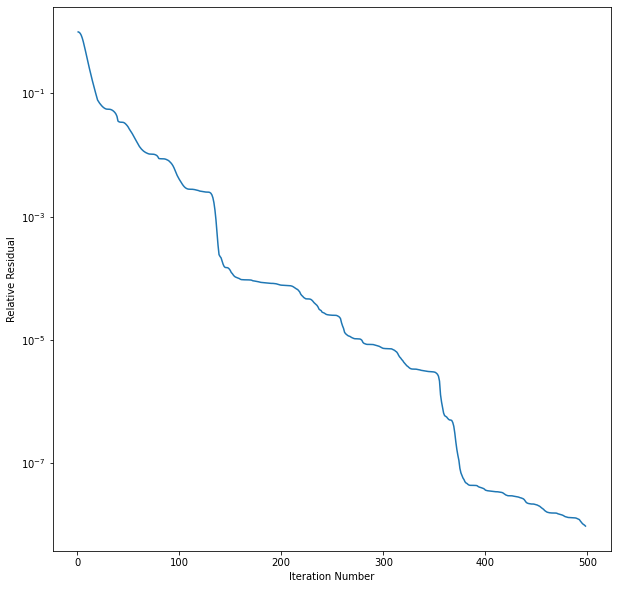

In [36]:
# Solve equations for n and p --- C{n_new} = D   --- E{p_new} = F

n_new = np.empty(Nn)


counter = gmres_counter()

n_new, info = gmres(C,D,tol=1e-8,callback=counter)
relres = np.asarray(counter.relres)
iterations = np.arange(1, relres.size+1,1)
figR = plt.figure(figsize=(10,10))
axR = figR.add_subplot(1,1,1)
axR.plot(iterations,relres)
axR.set_yscale('log')
axR.set_xlabel('Iteration Number')
axR.set_ylabel('Relative Residual')
    

Text(0, 0.5, 'Relative Residual')

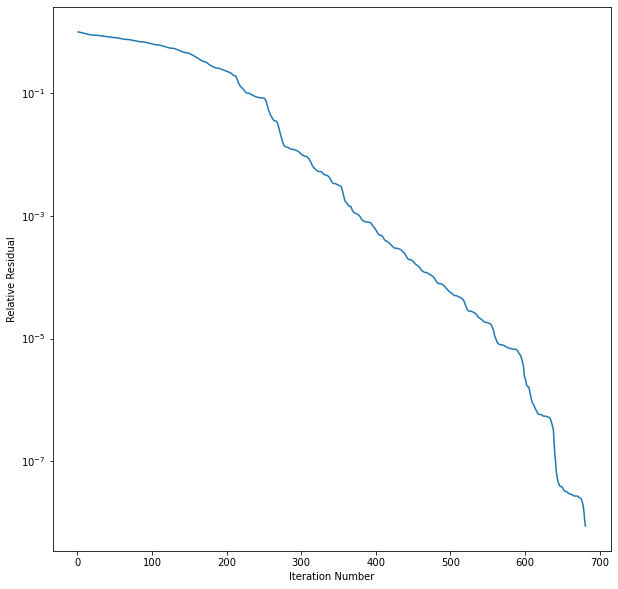

In [37]:
p_new = np.empty(Nn)

counter = gmres_counter()

p_new, info = gmres(E,F,tol=1e-8,callback=counter)
relres = np.asarray(counter.relres)
iterations = np.arange(1, relres.size+1,1)
figR = plt.figure(figsize=(10,10))
axR = figR.add_subplot(1,1,1)
axR.plot(iterations,relres)
axR.set_yscale('log')
axR.set_xlabel('Iteration Number')
axR.set_ylabel('Relative Residual')

Text(0, 0.5, 'Charge carrier density [n_i]')

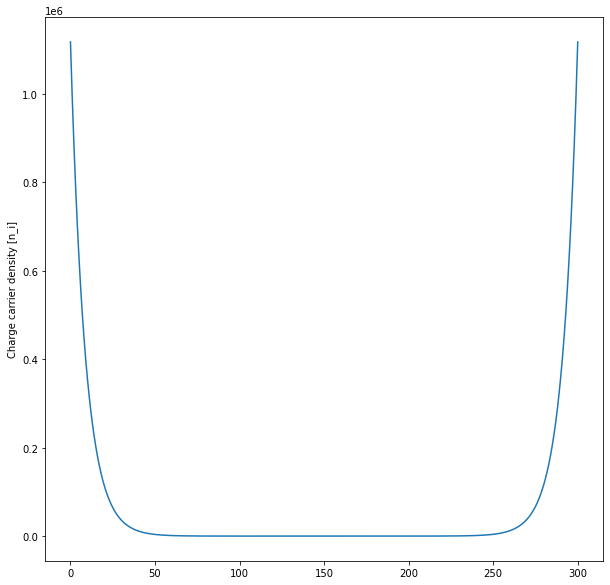

In [38]:
lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(lin,n_new)
ax.set_ylabel("Charge carrier density [n_i]")

In [39]:
# compute new p and n for given alfa

alfa = 0.01 #relaxation factor

p = (1-alfa)*p + alfa*p_new
n = (1-alfa)*n + alfa*n_new

Text(0, 0.5, 'Charge carrier density [n_i]')

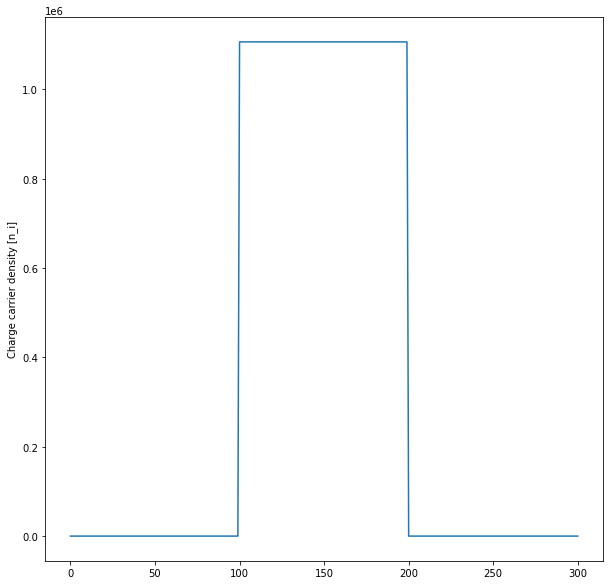

In [40]:
lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(lin,p)
ax.set_ylabel("Charge carrier density [n_i]")

In [41]:
#NOW ASSEMBLE ITERATION LOOP (DUPLICATE CODE)

iterations = 100
for i in range(iterations):
    #AV = B -- Matrix equation solved below - imposing boundary conditions
    A = sparse.lil_matrix.copy(F_1)
    B = sparse.lil_matrix.dot(F_2,(p-n+Nd-Na))
    A[0,0] = 0
    A[0,1] = 0
    A[0,0] = 1
    A[M-1,M-2] = 0
    A[M-1,M-1] = 0
    A[M-1,M] = 0
    A[M-1,M-1] = 1
    A[Nn-1,Nn-2] = 0
    A[Nn-1,Nn-1] = 0
    A[Nn-1,Nn-1] = 1


    B[0] = V_built_EB
    B[M-1] = 0
    B[Nn-1] = V_built_CB
    #---------------------------------------------------------------
    
    #Solve for initial potential V
    V, info = gmres(A,B,tol=1e-8,callback=counter)

    #Calculating matrix G^1 for a given potential distribution
    G_1[:,:] = 0
    %run G_matrix_assembly.ipynb
    
    #computing new recombination rate
    for i in range(Nn):
        U[i] = (n[i]*p[i] - 1)/(tau_p*(n[i]+1) + tau_n*(p[i]+1))
        
    #impose boundary condition for n_new and p_new calculations

    C = G_1.multiply(1/gamma_n) - F_1.multiply(1/gamma_n)
    C.tolil()
    D = sparse.lil_matrix.dot(F_2,U)

    C[0,0] = 0
    C[0,1] = 0
    C[0,0] = 1
    C[Nn-1,Nn-2] = 0
    C[Nn-1,Nn-1] = 0
    C[Nn-1,Nn-1] = 1

    D[0] = (1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2))))/n_norm
    D[Nn-1] = (1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2))))/n_norm


    E = G_1.multiply(1/gamma_p) - F_1.multiply(1/gamma_p)
    E.tolil()
    F = sparse.lil_matrix.dot(F_2,U)

    E[0,0] = 0
    E[0,1] = 0
    E[0,0] = 1
    E[Nn-1,Nn-2] = 0
    E[Nn-1,Nn-1] = 0
    E[Nn-1,Nn-1] = 1

    F[0] = 1/((1/2*(N_DE + m.sqrt(N_DE**2 + 4*(n_norm**2))))/n_norm)
    F[Nn-1] = 1/((1/2*(N_DC + m.sqrt(N_DC**2 + 4*(n_norm**2))))/n_norm)
    
    # Solve equations for n and p --- C{n_new} = D   --- E{p_new} = F
    
    n_new, info = gmres(C,D,tol=1e-8,callback=counter)
    p_new, info = gmres(E,F,tol=1e-8,callback=counter)
    
    # compute new p and n for given alfa

    alfa = 0.01 #relaxation factor

    p = (1-alfa)*p + alfa*p_new
    n = (1-alfa)*n + alfa*n_new

Text(0, 0.5, 'Charge carrier density [n_i]')

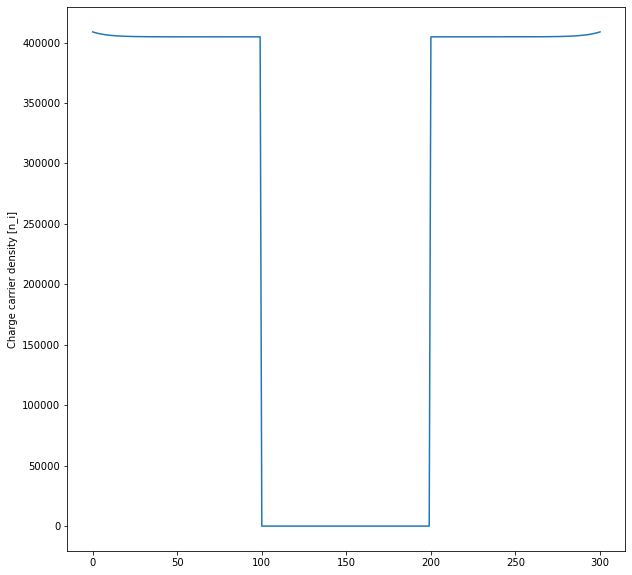

In [43]:
lin = np.linspace(0,Ne, Ne+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(lin,n)
ax.set_ylabel("Charge carrier density [n_i]")